In [1]:
import state_space_system
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams
import numpy as np
from casadi import *

from ERA import *
from kalman_filter import *
from utils_optimization_problem import *

mpl.rcParams['font.size'] = 16 # set the matplotlib parameter

## 1. System Identification ##

In [2]:
## system identification ##
q = 2   # Number of inputs
p = 3   # Number of outputs
r = 10  # Reduced model order

time = np.linspace(0, 20, num=500)
sys = state_space_system.sys()# import real system
sys.reset()
u = np.zeros((time.shape[0]-1, 2))
u[0,0] = 1
u1 = u

u = np.zeros((time.shape[0]-1, 2))
u[0,1] = 1
u2 = u

# average of 10 times measurement

re = 10 # repeated time for measurement

y_1 = np.zeros((time.shape[0],3))
y_2 = np.zeros((time.shape[0],3))
for n in range(re):
    y_1_t = sys.simulate(time, u1)
    # Concatenate:
    y_1_t = np.array(y_1_t)
    y_1 += y_1_t

    y_2_t = sys.simulate(time, u2)
    # Concatenate:
    y_2_t = np.array(y_2_t)
    y_2 += y_2_t
y_1 /= re
y_2 /= re

yFull = np.zeros((time.shape[0],p,q))

yFull[:,:,0] = y_1[:,:]
yFull[:,:,1] = y_2[:,:]

YY = np.transpose(yFull,axes=(1,2,0)) # reorder to size p x q x m 

# Compute reduced order model from impulse response
mco = int(np.floor((yFull.shape[0]-1)/2)) # m_c = m_o = (m-1)/2
Ar,Br,Cr,Dr,HSVs = ERA(YY,mco,mco,q,p,r)

# impulse response test for channel 1
y1 = []
x0 = np.zeros((Ar.shape[1],1)) 

for n in range(u1.shape[0]):
    temp = Cr@x0 + Dr@(u1[n]).reshape(Dr.shape[1],1)
    y1.append(temp)
    x0 = Ar@x0 + Br@(u1[n]).reshape(Dr.shape[1],1)
y1.append(Cr@x0)
# impulse response test for channel 2  
y2 = []
x0 = np.zeros((Ar.shape[1],1))

for n in range(u2.shape[0]):
    temp = Cr@x0 + Dr@(u2[n]).reshape(Dr.shape[1],1)
    y2.append(temp)
    x0 = Ar@x0 + Br@(u2[n]).reshape(Dr.shape[1],1)
y2.append(Cr@x0)

y1 = (np.array(y1)).reshape(time.shape[0],3)
y2 = (np.array(y2)).reshape(time.shape[0],3)

Text(0.5, 1.0, 'third mass')

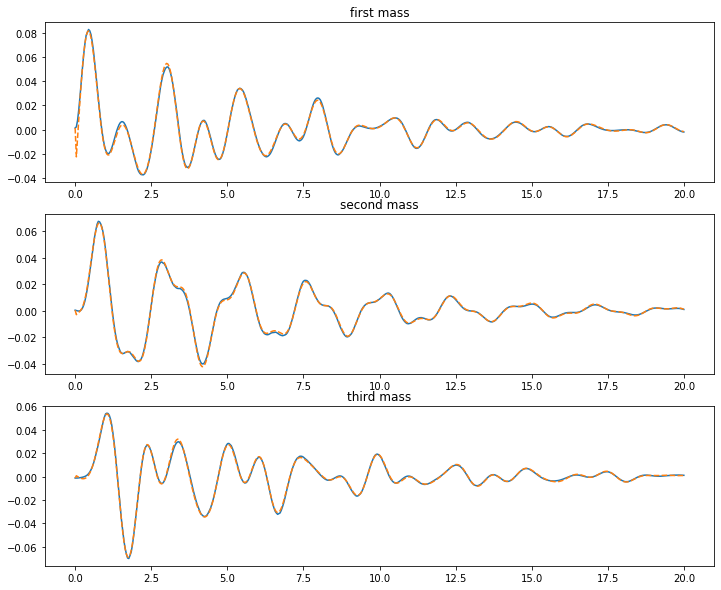

In [3]:
## ident sys. and original sys. ##
fig, (ax1, ax2, ax3) = plt.subplots(3,figsize=(12,10))
ax1.plot(time, y_1[:,0])
ax1.plot(time, y1[:,0], '--')
ax1.set_title('first mass')
ax2.plot(time, y_1[:,1])
ax2.plot(time, y1[:,1], '--')
ax2.set_title('second mass')
ax3.plot(time, y_1[:,2])
ax3.plot(time, y1[:,2], '--')
ax3.set_title('third mass')

In [4]:
## Augmented system ##
Ab,Bb,Cb = augmented_system(Ar,Br,Cr)

nx = Ab.shape[1] #set the number of state and the control inputs
nu = Bb.shape[1]
ny = Cb.shape[0]

In [5]:
## create a symbolic expression of state space ##
x = SX.sym("x",nx,1)
delta_u = SX.sym("delta_u",nu,1)

x_next = Ab@x + Bb@delta_u
system = Function("sys",[x,delta_u],[x_next]) # Create the CasADi function

In [6]:
## MPC initialization and casadi objective function ##
Q = 10                    # make it larger to get a more aggresive controller
Q = Q*np.diag(np.ones(ny)) # the state cost mutiplyer by using the output channel: ny=3

S = Q # S for terminal cost is equal to Q

R = 1                     # set it to 1, trying to reduce the influence from the control energy term
R = np.diag(R*np.ones(nu)) # the cost of control

N = 30                     # horizon

y_Ref = SX.sym("y_ref",ny,1)   # desired trajectory

# state cost
stage_cost = (y_Ref-Cb@x).T@Q@(y_Ref-Cb@x)+ delta_u.T@R@delta_u
stage_cost_fcn = Function('stage_cost',[x,delta_u,y_Ref],[stage_cost])

# terminal cost
terminal_cost = (y_Ref-Cb@x).T@S@(y_Ref-Cb@x)
terminal_cost_fcn = Function('terminal_cost',[x,y_Ref],[terminal_cost])

In [7]:
Q[2,2] = 0
S[2,2] = 0

In [8]:
# delta_u changing rate per step constraints
lb_u = -3*np.ones((nu,1))
ub_u = 3*np.ones((nu,1))

# equality constraints to limit the control inout
_lbg = -5*np.ones((nu,1))
_ubg = 5*np.ones((nu,1))

In [9]:
## create optimization problem ##
def casadi_setting_seq(nx,nu): # reference_signal
    
    #X = SX.sym("X",(N+1)*nx,1)
    delta_U = SX.sym("delta_U",N*nu,1)
    xt = SX.sym("xt",nx,1)
    reference_signal = SX.sym("r",N,ny)
    
    J = 0
    
    lb_X = [] # lower bound for xt.
    ub_X = [] # upper bound for xt
    lb_U = [] # lower bound for delta_U
    ub_U = [] # upper bound for delta_U
    g = []    # constraint expression g
    lb_g = []  # lower bound for constraint expression g
    ub_g = []  # upper bound for constraint expression g
    
    x_step = xt # init step
    for k in range(N):
        # Retrieve parameters
        delta_u_k = delta_U[k*nu:(k+1)*nu,:]

        # objective
        J += stage_cost_fcn(x_step,delta_u_k,reference_signal[k,:])

        # add equality constraints
        g.append(x_step[10:] + delta_u_k)
        lb_g.append(_lbg)
        ub_g.append(_ubg)
        # representing next state using system formula
        x_step = system(x_step,delta_u_k)
        
        # add input signal constraints 
        lb_U.append(lb_u)
        ub_U.append(ub_u)

    # add terminal cost
    x_terminal = x_step
    J += terminal_cost_fcn(x_terminal,reference_signal[-1,:])

    return lb_U,ub_U,lb_X,ub_X,lb_g,ub_g,g,delta_U,xt,J,reference_signal

In [10]:
#X = SX.sym("X",(N+1)*nx,1)
delta_U = SX.sym("delta_U",N*nu,1)
xt = SX.sym("xt",nx,1)
reference_signal = SX.sym("r",N,ny)
    
J = 0
    
lb_X = [] # lower bound for xt.
ub_X = [] # upper bound for xt
lb_U = [] # lower bound for delta_U
ub_U = [] # upper bound for delta_U
g = []    # constraint expression g
lb_g = []  # lower bound for constraint expression g
ub_g = []  # upper bound for constraint expression g
    
x_step = xt # init step
k = 0
delta_u_k = delta_U[k*nu:(k+1)*nu,:]

J += stage_cost_fcn(x_step,delta_u_k,reference_signal[k,:])


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equa

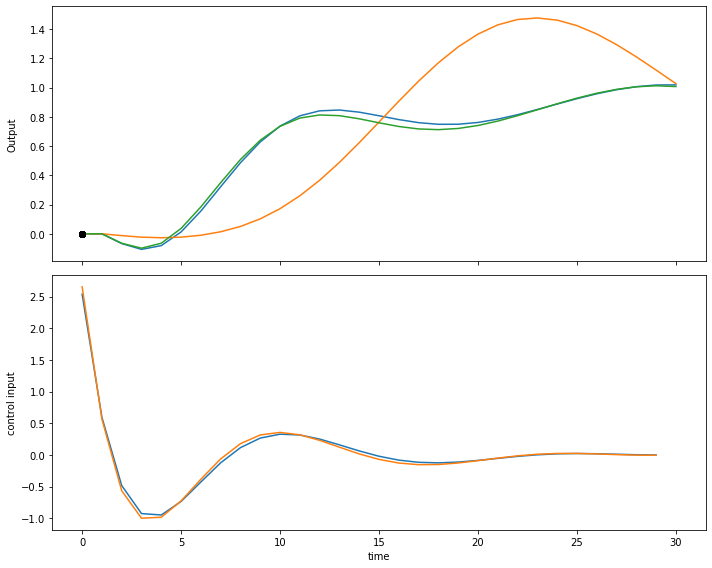

In [11]:
## test the functional solver production ##
reference = np.ones((N,ny))

lb_U,ub_U,lb_X,ub_X,lb_g,ub_g,g,delta_U,xt,J,param = casadi_setting_seq(nx,nu)
# Casadi solver
x_0 = np.zeros((nx,1))
lb_X.append(x_0)
ub_X.append(x_0)

lbx = vertcat(*lb_X,*lb_U)
ubx = vertcat(*lb_X,*ub_U)
x = vertcat(xt,delta_U)
g = vertcat(*g)
lbg = vertcat(*lb_g)
ubg = vertcat(*ub_g)
#reference = vertcat(*reference)
param = vertcat(param)

prob = {'f':J,'p':param,'x':x,'g':g}
solver = nlpsol('solver','ipopt',prob)

res = solver(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg,p=reference)

#X = res['x'][:(N+1)*nx].full().reshape(N+1, nx)
delta_U = res['x'][nx:].full().reshape(N, nu)
Y = np.zeros((ny,1))

x_test = np.zeros((nx,1))

for n in range(N):
    Y = np.hstack((Y,Cb@x_test))
    x_test = Ab@x_test + Bb@(delta_U[n]).reshape(2,1)
# visulization of the result   

fig, ax = plt.subplots(2,1, figsize=(10,8), sharex=True)
ax[0].plot(Y.T)
ax[1].plot(delta_U)
ax[0].set_ylabel('Output')
ax[1].set_ylabel('control input')
ax[1].set_xlabel('time')

# Highlight the selected initial state (the lines should start here!)
ax[0].plot(0,x_0.T, 'o', color='black')

fig.align_ylabels()
fig.tight_layout()
## test result looks resonable

In [12]:
N_sim = 500 # total simulation step
time = np.linspace(1,20,num = N_sim)
#################################### compensate for the last time step for 13 units shape:(3, 513)
REFERENCE = np.ones((ny,N_sim+N-1))
# constant tracking
REFERENCE[:,150:] = 2
REFERENCE[:,400:] = 1
# trigonometric tracking
#REFERENCE[0,:] = np.array(np.sin(np.linspace(-3*np.pi, 3*np.pi, N_sim+N-1))).T
#REFERENCE[1,:] = np.array(np.sin(np.linspace(-3*np.pi+2*np.pi/3, 3*np.pi+2*np.pi/3, N_sim+N-1))).T
#REFERENCE[2,:] = np.array(np.sin(np.linspace(-3*np.pi+2*2*np.pi/3, 3*np.pi+2*2*np.pi/3, N_sim+N-1))).T
# linear tracking
#REFERENCE[:,0:100] = 0
#REFERENCE[:,100:250] = np.linspace(0,3,250-100)
#REFERENCE[:,250:400] = np.linspace(3,0,400-250)
#REFERENCE[:,400:] = 0
# Acceleration signal
#REFERENCE[:,0:150] = 0
#REFERENCE[:,150:350] = (np.linspace(0,2.5,200))**2
#REFERENCE[:,350:] = 0

#################################### reference change test

In [13]:
%%time
## MPC main loop ##
x_0 = np.zeros((nx,1))
#u_0 = np.zeros((nu,1))
res_x = [x_0]
res_delta_u = []
res_u = []

## original system measurement initialization
sys.reset()
y_res = [sys.make_measurement()]

## kalman filter parameters
P_k = np.eye(Ab.shape[0],Ab.shape[1])
Q_k = np.ones((Ab.shape[0],Ab.shape[1]))
R_k = np.eye(Cb.shape[0],Cb.shape[0])

for i in range(N_sim-1):
    ############## create casadi solver
    reference = REFERENCE[:,i:i+N].T
    lb_U,ub_U,lb_X,ub_X,lb_g,ub_g,g,delta_U,xt,J,param = casadi_setting_seq(nx,nu)
    
    # Casadi solver
    lb_X.append(x_0)
    ub_X.append(x_0)
    
    lbx = vertcat(*lb_X,*lb_U)
    ubx = vertcat(*lb_X,*ub_U)
    x = vertcat(xt,delta_U)
    g = vertcat(*g)
    lbg = vertcat(*lb_g)
    ubg = vertcat(*ub_g)
    # only create solver at time step 1
    if i == 0:
        prob = {'f':J,'p':param,'x':x,'g':g}
        solver = nlpsol('solver','ipopt',prob)

    res = solver(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg,p=reference)
    ###############
    
    _xt = res['x'][:nx].full()
    
    del_U = res['x'][nx:].full().reshape(N, nu)
    del_u = (del_U[0,:]).reshape(nu,1)
    
    res_delta_u.append(del_u)
    # calculate the simulating input signal
    u_st = (_xt[10:]+del_u).reshape(nu,1)
    res_u.append(u_st)
    
    # simulate the original system
    sys.simulate(time[i:i+2], (u_st).reshape(1,nu))
    
    # Append new measurement
    y_res.append(sys.make_measurement())
    
    # state Estimation
    xpred, Ppred = predict(x_0, (del_u).reshape(Bb.shape[1],1), P_k, Ab, Q_k, Bb)
    K = K_G(P_k,Cb,R_k)
    x_next,P_k = update(xpred,K,y_res[i+1],Cb,P_k,R_k,Ab)
    #x_next = system(x_0,del_u)
    
    assert np.max(x_next[10:nx]) < 6 or np.min(x_next[10:nx]) > -4 # avoid surpassing the allowable range
    
    res_x.append(x_next)
    # update the current system state
    x_0 = x_next

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

   2 9.4770232e+001 0.00e+000 1.19e-013  -1.0 4.77e-001    -  1.00e+000 1.00e+000f  1
   3 9.3995774e+001 0.00e+000 3.59e-003  -2.5 8.08e-001    -  8.87e-001 1.00e+000f  1
   4 9.3931478e+001 0.00e+000 2.45e-013  -2.5 4.15e-001    -  1.00e+000 1.00e+000f  1
   5 9.3930392e+001 0.00e+000 3.04e-013  -3.8 6.08e-002    -  1.00e+000 1.00e+000f  1
   6 9.3930390e+001 0.00e+000 3.28e-013  -5.7 2.76e-003    -  1.00e+000 1.00e+000f  1
   7 9.3930390e+001 0.00e+000 1.50e-013  -8.6 1.85e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.7237138230245851e+001   9.3930389797579267e+001
Dual infeasibility......:  1.5028338653228106e-013   8.1893971542839444e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5158331606182129e-009   1.3709537295923518e-008
Overall NLP error.......:  2.5158331606182129e-009   1.3709537295923518e-00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 6

   2 2.8525101e+001 0.00e+000 4.00e-013  -1.0 1.19e-001    -  1.00e+000 1.00e+000f  1
   3 2.8474353e+001 0.00e+000 4.62e-004  -2.5 3.08e-001    -  9.78e-001 1.00e+000f  1
   4 2.8472272e+001 0.00e+000 1.68e-013  -3.8 8.23e-002    -  1.00e+000 1.00e+000f  1
   5 2.8472271e+001 0.00e+000 4.05e-013  -5.7 2.35e-003    -  1.00e+000 1.00e+000f  1
   6 2.8472271e+001 0.00e+000 6.00e-014  -8.6 8.74e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  1.3570444527777392e+001   2.8472270598407523e+001
Dual infeasibility......:  6.0012401483928128e-014   1.2591255436129246e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5111615678119237e-009   5.2686904639499383e-009
Overall NLP error.......:  2.5111615678119237e-009   5.2686904639499383e-009


Number of objective function evaluations             = 7
Number of objective gradi

                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 5.4140976e+001 0.00e+000 4.86e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 2.1599713e+001 0.00e+000 2.44e-002  -1.0 6.29e-001    -  9.09e-001 1.00e+000f  1
   2 2.1439454e+001 0.00e+000 4.01e-003  -1.7 2.35e-001    -  9.83e-001 1.00e+000f  1
   3 2.1432378e+001 0.00e+000 4.12e-013  -2.5 1.49e-001    -  1.00e+000 1.00e+000f  1
   4 2.1432349e+001 0.00e+000 8.20e-014  -3.8 1.00e-002    -  

   6 1.5397406e+001 0.00e+000 2.87e-014  -8.6 2.69e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  3.7483286236976752e+000   1.5397405826428782e+001
Dual infeasibility......:  2.8692426431141345e-014   1.1786291391639406e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5292649430937011e-009   1.0389729044876319e-008
Overall NLP error.......:  2.5292649430937011e-009   1.0389729044876319e-008


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 7
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 7
Number of Lagrangian Hessian evaluations             = 6
Total CPU secs in IPOPT (w/

   2 8.1873435e+000 0.00e+000 4.86e-004  -1.7 1.07e-001    -  9.98e-001 1.00e+000f  1
   3 8.1293951e+000 0.00e+000 9.75e-014  -2.5 3.42e-001    -  1.00e+000 1.00e+000f  1
   4 8.1284728e+000 0.00e+000 2.47e-014  -3.8 5.32e-002    -  1.00e+000 1.00e+000f  1
   5 8.1284716e+000 0.00e+000 2.29e-014  -5.7 2.00e-003    -  1.00e+000 1.00e+000f  1
   6 8.1284716e+000 0.00e+000 2.06e-014  -8.6 1.33e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  1.5931964342004674e+000   8.1284715838663750e+000
Dual infeasibility......:  2.0597846235873934e-014   1.0508999657733550e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5124282451583911e-009   1.2818382692101592e-008
Overall NLP error.......:  2.5124282451583911e-009   1.2818382692101592e-008


Number of objective function evaluations             = 7
Number of objective gradi

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4.6726165e+001 0.00e+000 6.91e+000  -1.0 0.00e+000    -  0.00e+00

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1.7586092e+001 0.00e+000 5.26e+000  -1.0 0.00e+000    -  0.00e+00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 6

   4 2.1357715e+000 0.00e+000 2.47e-013  -5.7 1.70e-003    -  1.00e+000 1.00e+000f  1
   5 2.1357715e+000 0.00e+000 2.63e-013  -8.6 5.91e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  8.9161152229220653e-001   2.1357714982416569e+000
Dual infeasibility......:  2.6284025557522708e-013   6.2960909814728362e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5087783050156402e-009   6.0095423458462111e-009
Overall NLP error.......:  2.5087783050156402e-009   6.0095423458462111e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 5

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

   1 1.7208659e+000 0.00e+000 2.76e-003  -1.0 2.14e-001    -  9.72e-001 1.00e+000f  1
   2 1.6990413e+000 0.00e+000 8.15e-014  -1.7 1.23e-001    -  1.00e+000 1.00e+000f  1
   3 1.6979001e+000 0.00e+000 1.63e-013  -3.8 5.93e-002    -  1.00e+000 1.00e+000f  1
   4 1.6978991e+000 0.00e+000 3.61e-013  -5.7 1.84e-003    -  1.00e+000 1.00e+000f  1
   5 1.6978991e+000 0.00e+000 3.87e-013  -8.6 3.57e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  1.5465521114428991e+000   1.6978990858579386e+000
Dual infeasibility......:  3.8734053839487831e-013   4.2524603030854135e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5078653675277865e-009   2.7532873179472084e-009
Overall NLP error.......:  2.5078653675277865e-009   2.7532873179472084e-009


Number of objective function evaluations             = 6
Number of objective gradi

   1 1.3954064e+000 0.00e+000 1.28e-003  -1.0 1.49e-001    -  9.82e-001 1.00e+000f  1
   2 1.3890322e+000 0.00e+000 5.74e-013  -1.7 8.92e-002    -  1.00e+000 1.00e+000f  1
   3 1.3885731e+000 0.00e+000 3.57e-013  -3.8 4.11e-002    -  1.00e+000 1.00e+000f  1
   4 1.3885728e+000 0.00e+000 3.17e-013  -5.7 1.17e-003    -  1.00e+000 1.00e+000f  1
   5 1.3885728e+000 0.00e+000 5.13e-013  -8.6 2.83e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  1.3885728012251279e+000   1.3885728012251279e+000
Dual infeasibility......:  5.1301083054186022e-013   5.1301083054186022e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5073462753756327e-009   2.5073462753756327e-009
Overall NLP error.......:  2.5073462753756327e-009   2.5073462753756327e-009


Number of objective function evaluations             = 6
Number of objective gradi

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

   5 7.6520688e-001 0.00e+000 4.32e-013  -8.6 2.50e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  7.6520687624213579e-001   7.6520687624213579e-001
Dual infeasibility......:  4.3154769462886142e-013   4.3154769462886142e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5071019635771312e-009   2.5071019635771312e-009
Overall NLP error.......:  2.5071019635771312e-009   2.5071019635771312e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 6
Number of Lagrangian Hessian evaluations             = 5
Total CPU secs in IPOPT (w/

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2.4673257e+000 0.00e+000 2.33e+000  -1.0 0.00e+000    -  0.00e+00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

   0 1.1265839e+000 0.00e+000 5.14e-001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 8.3996856e-001 0.00e+000 1.31e-004  -1.0 6.16e-002    -  9.96e-001 1.00e+000f  1
   2 8.3604801e-001 0.00e+000 3.23e-013  -2.5 7.36e-002    -  1.00e+000 1.00e+000f  1
   3 8.3600315e-001 0.00e+000 2.11e-013  -3.8 1.29e-002    -  1.00e+000 1.00e+000f  1
   4 8.3600312e-001 0.00e+000 3.02e-013  -5.7 2.53e-004    -  1.00e+000 1.00e+000h  1
   5 8.3600312e-001 0.00e+000 1.70e-013  -8.6 2.57e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  8.3600312405275889e-001   8.3600312405275889e-001
Dual infeasibility......:  1.7008508655853329e-013   1.7008508655853329e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5071476969245095e-009   2.5071476969245095e-009
Overall NLP error.......:  2.5071476969245095e-009   2.5071476969245095e-00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

   3 6.6704167e-001 0.00e+000 4.89e-013  -3.8 1.32e-002    -  1.00e+000 1.00e+000f  1
   4 6.6704165e-001 0.00e+000 8.43e-014  -5.7 2.50e-004    -  1.00e+000 1.00e+000h  1
   5 6.6704165e-001 0.00e+000 4.45e-014  -8.6 2.52e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  6.6704165206892241e-001   6.6704165206892241e-001
Dual infeasibility......:  4.4467316574590496e-014   4.4467316574590496e-014
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5071125043497698e-009   2.5071125043497698e-009
Overall NLP error.......:  2.5071125043497698e-009   2.5071125043497698e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6
Number of equality constra

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2.2175790e+000 0.00e+000 2.23e+000  -1.0 0.00e+000    -  0.00e+00

   3 8.5263961e-001 0.00e+000 2.63e-013  -3.8 8.74e-003    -  1.00e+000 1.00e+000f  1
   4 8.5263959e-001 0.00e+000 2.41e-013  -5.7 2.34e-004    -  1.00e+000 1.00e+000h  1
   5 8.5263959e-001 0.00e+000 3.99e-013  -8.6 2.56e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  8.5263958971137133e-001   8.5263958971137133e-001
Dual infeasibility......:  3.9896742927183937e-013   3.9896742927183937e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5071436899133336e-009   2.5071436899133336e-009
Overall NLP error.......:  2.5071436899133336e-009   2.5071436899133336e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6
Number of equality constra

   0 1.6344824e+000 0.00e+000 1.38e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 8.2321181e-001 0.00e+000 1.93e-004  -1.0 6.96e-002    -  9.95e-001 1.00e+000f  1
   2 8.2056424e-001 0.00e+000 4.56e-014  -2.5 6.58e-002    -  1.00e+000 1.00e+000f  1
   3 8.2052791e-001 0.00e+000 1.43e-013  -3.8 1.22e-002    -  1.00e+000 1.00e+000f  1
   4 8.2052789e-001 0.00e+000 1.83e-013  -5.7 2.46e-004    -  1.00e+000 1.00e+000h  1
   5 8.2052789e-001 0.00e+000 5.56e-013  -8.6 2.53e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  8.2052789246770630e-001   8.2052789246770630e-001
Dual infeasibility......:  5.5612504570571118e-013   5.5612504570571118e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5071200163103824e-009   2.5071200163103824e-009
Overall NLP error.......:  2.5071200163103824e-009   2.5071200163103824e-00

   2 6.8906748e-001 0.00e+000 6.53e-014  -2.5 7.36e-002    -  1.00e+000 1.00e+000f  1
   3 6.8902833e-001 0.00e+000 1.94e-013  -3.8 1.32e-002    -  1.00e+000 1.00e+000f  1
   4 6.8902831e-001 0.00e+000 2.79e-013  -5.7 2.51e-004    -  1.00e+000 1.00e+000h  1
   5 6.8902831e-001 0.00e+000 6.54e-014  -8.6 2.52e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  6.8902830892403399e-001   6.8902830892403399e-001
Dual infeasibility......:  6.5427707034343869e-014   6.5427707034343869e-014
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5071170066702457e-009   2.5071170066702457e-009
Overall NLP error.......:  2.5071170066702457e-009   2.5071170066702457e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            =

   0 7.4464460e-001 0.00e+000 5.72e-001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 6.2398996e-001 0.00e+000 2.74e-013  -1.0 3.47e-002    -  1.00e+000 1.00e+000f  1
   2 6.2231797e-001 0.00e+000 6.63e-013  -2.5 6.11e-002    -  1.00e+000 1.00e+000f  1
   3 6.2229594e-001 0.00e+000 1.55e-014  -3.8 1.01e-002    -  1.00e+000 1.00e+000f  1
   4 6.2229593e-001 0.00e+000 3.90e-013  -5.7 2.39e-004    -  1.00e+000 1.00e+000h  1
   5 6.2229593e-001 0.00e+000 7.36e-013  -8.6 2.55e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  6.2229592524725907e-001   6.2229592524725907e-001
Dual infeasibility......:  7.3639266268610612e-013   7.3639266268610612e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5071355653961828e-009   2.5071355653961828e-009
Overall NLP error.......:  2.5071355653961828e-009   2.5071355653961828e-00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

   0 3.0194213e+002 0.00e+000 5.24e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 3.9321246e+001 0.00e+000 8.80e-002  -1.0 1.24e+000    -  8.32e-001 1.00e+000f  1
   2 3.0769961e+001 0.00e+000 9.49e-014  -1.0 6.23e-001    -  1.00e+000 1.00e+000f  1
   3 2.9974395e+001 0.00e+000 1.55e-013  -1.7 5.20e-001    -  1.00e+000 1.00e+000f  1
   4 2.9921492e+001 0.00e+000 1.05e-013  -2.5 3.15e-001    -  1.00e+000 1.00e+000f  1
   5 2.9920327e+001 0.00e+000 1.06e-014  -3.8 6.20e-002    -  1.00e+000 1.00e+000f  1
   6 2.9920324e+001 0.00e+000 9.86e-014  -5.7 2.94e-003    -  1.00e+000 1.00e+000f  1
   7 2.9920324e+001 0.00e+000 9.91e-014  -8.6 2.23e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  6.6867899913181734e+000   2.9920324290731497e+001
Dual infeasibility......:  9.9082261571833591e-014   4.4334776500195351e-013
Constraint violation....:  0.0000000000000000e+000   0.00

   5 3.2059980e+001 0.00e+000 9.48e-014  -3.8 1.04e-002    -  1.00e+000 1.00e+000f  1
   6 3.2059980e+001 0.00e+000 2.96e-013  -5.7 5.82e-004    -  1.00e+000 1.00e+000h  1
   7 3.2059980e+001 0.00e+000 3.05e-013  -8.6 6.47e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.2096053694949367e+001   3.2059980107219808e+001
Dual infeasibility......:  3.0452319700091636e-013   8.0712337132835643e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5090654347484349e-009   6.6501513596401368e-009
Overall NLP error.......:  2.5090654347484349e-009   6.6501513596401368e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 8
Number of equality constra

   0 1.0191326e+002 0.00e+000 6.73e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 4.2288378e+001 0.00e+000 5.08e-002  -1.0 9.22e-001    -  8.79e-001 1.00e+000f  1
   2 4.1213722e+001 0.00e+000 3.73e-013  -1.0 2.99e-001    -  1.00e+000 1.00e+000f  1
   3 4.1118370e+001 0.00e+000 1.89e-003  -2.5 3.81e-001    -  9.72e-001 1.00e+000f  1
   4 4.1115837e+001 0.00e+000 2.24e-013  -3.8 9.70e-002    -  1.00e+000 1.00e+000f  1
   5 4.1115834e+001 0.00e+000 1.51e-013  -5.7 3.56e-003    -  1.00e+000 1.00e+000f  1
   6 4.1115834e+001 0.00e+000 2.89e-013  -8.6 1.25e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  2.4747271335371536e+001   4.1115834158163352e+001
Dual infeasibility......:  2.8904585667248785e-013   4.8022916732899851e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5168545728345150e-009   4.18157516497

   1 5.1495527e+001 0.00e+000 4.11e-002  -1.0 8.26e-001    -  8.88e-001 1.00e+000f  1
   2 4.8994967e+001 0.00e+000 1.95e-002  -1.7 3.27e-001    -  9.31e-001 1.00e+000f  1
   3 4.8619021e+001 0.00e+000 2.47e-003  -2.5 5.95e-001    -  9.58e-001 1.00e+000f  1
   4 4.8604044e+001 0.00e+000 2.35e-013  -3.8 2.22e-001    -  1.00e+000 1.00e+000f  1
   5 4.8603977e+001 0.00e+000 6.08e-014  -5.7 1.79e-002    -  1.00e+000 1.00e+000f  1
   6 4.8603977e+001 0.00e+000 2.87e-013  -8.6 1.26e-004    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  1.2157507881509009e+001   4.8603977367315018e+001
Dual infeasibility......:  2.8724207237355119e-013   1.1483527151003475e-012
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.9208335018628666e-009   1.1677074512463110e-008
Overall NLP error.......:  2.9208335018628666e-009   1.1677074512463110e-00

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1.8576718e+002 0.00e+000 6.62e+000  -1.0 0.00e+000    -  0.00e+00

   5 4.8421606e+001 0.00e+000 1.24e-013  -5.7 1.33e-003    -  1.00e+000 1.00e+000f  1
   6 4.8421606e+001 0.00e+000 1.03e-013  -8.6 1.19e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  2.0887623760861025e+001   4.8421605934111803e+001
Dual infeasibility......:  1.0266394343994050e-013   2.3799514343061021e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5134429696341754e-009   5.8266534483227823e-009
Overall NLP error.......:  2.5134429696341754e-009   5.8266534483227823e-009


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 7
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 

   1 4.7392010e+001 0.00e+000 1.22e-001  -1.0 9.52e-001    -  7.43e-001 1.00e+000f  1
   2 4.5138115e+001 0.00e+000 5.34e-013  -1.0 2.55e-001    -  1.00e+000 1.00e+000f  1
   3 4.5021529e+001 0.00e+000 6.53e-005  -2.5 9.56e-002    -  9.98e-001 1.00e+000f  1
   4 4.5017151e+001 0.00e+000 2.11e-013  -3.8 9.01e-002    -  1.00e+000 1.00e+000f  1
   5 4.5017140e+001 0.00e+000 1.14e-014  -5.7 6.09e-003    -  1.00e+000 1.00e+000f  1
   6 4.5017140e+001 0.00e+000 2.90e-014  -8.6 4.97e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  8.0117584174641010e+000   4.5017139852194703e+001
Dual infeasibility......:  2.8962147901813502e-014   1.6273494463760491e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5515145397193798e-009   1.4336663798933149e-008
Overall NLP error.......:  2.5515145397193798e-009   1.4336663798933149e-00

   2 2.7036455e+001 0.00e+000 1.58e-002  -1.7 5.01e-001    -  9.54e-001 1.00e+000f  1
   3 2.5901447e+001 0.00e+000 5.12e-003  -2.5 9.16e-001    -  9.12e-001 1.00e+000f  1
   4 2.5796560e+001 0.00e+000 9.52e-006  -3.8 4.64e-001    -  9.99e-001 1.00e+000f  1
   5 2.5794353e+001 0.00e+000 1.04e-013  -3.8 7.64e-002    -  1.00e+000 1.00e+000f  1
   6 2.5794342e+001 0.00e+000 1.25e-013  -5.7 5.81e-003    -  1.00e+000 1.00e+000f  1
   7 2.5794342e+001 0.00e+000 1.62e-013  -8.6 6.55e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  3.8013911066496044e+000   2.5794342343634998e+001
Dual infeasibility......:  1.6203782148225161e-013   1.0995077650964983e-012
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5692339114329313e-009   1.7433538726507591e-008
Overall NLP error.......:  2.5692339114329313e-009   1.7433538726507591e-00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

   1 9.9160290e+000 0.00e+000 1.92e-002  -1.0 5.46e-001    -  9.30e-001 1.00e+000f  1
   2 9.5949601e+000 0.00e+000 1.23e-013  -1.7 1.36e-001    -  1.00e+000 1.00e+000f  1
   3 9.5721901e+000 0.00e+000 3.26e-013  -2.5 2.37e-001    -  1.00e+000 1.00e+000f  1
   4 9.5717572e+000 0.00e+000 5.30e-013  -3.8 3.68e-002    -  1.00e+000 1.00e+000f  1
   5 9.5717564e+000 0.00e+000 6.34e-013  -5.7 1.58e-003    -  1.00e+000 1.00e+000f  1
   6 9.5717564e+000 0.00e+000 2.48e-013  -8.6 1.37e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  4.5581769784020869e+000   9.5717564043211940e+000
Dual infeasibility......:  2.4776648437824082e-013   5.2028704564581144e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5159530908831014e-009   5.2832722873068953e-009
Overall NLP error.......:  2.5159530908831014e-009   5.2832722873068953e-00

   6 6.3554538e+000 0.00e+000 1.80e-013  -8.6 2.21e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  1.9423209400960681e+000   6.3554537797026507e+000
Dual infeasibility......:  1.8033709093705737e-013   5.9007964263610007e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5226146220905957e-009   8.2542283840619475e-009
Overall NLP error.......:  2.5226146220905957e-009   8.2542283840619475e-009


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 7
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 7
Number of Lagrangian Hessian evaluations             = 6
Total CPU secs in IPOPT (w/

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

   3 3.3805489e+000 0.00e+000 1.43e-005  -3.8 8.15e-002    -  9.98e-001 1.00e+000f  1
   4 3.3805452e+000 0.00e+000 9.89e-013  -5.7 3.75e-003    -  1.00e+000 1.00e+000f  1
   5 3.3805452e+000 0.00e+000 1.07e-013  -8.6 1.09e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  3.3805451950774987e+000   3.3805451950774987e+000
Dual infeasibility......:  1.0654651625941774e-013   1.0654651625941774e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5185936937673211e-009   2.5185936937673211e-009
Overall NLP error.......:  2.5185936937673211e-009   2.5185936937673211e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6
Number of equality constra

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

   0 8.6890524e+000 0.00e+000 4.06e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 2.8144422e+000 0.00e+000 2.20e-003  -1.0 1.77e-001    -  9.79e-001 1.00e+000f  1
   2 2.7957157e+000 0.00e+000 7.88e-013  -1.7 1.31e-001    -  1.00e+000 1.00e+000f  1
   3 2.7933464e+000 0.00e+000 1.81e-005  -3.8 9.01e-002    -  9.97e-001 1.00e+000f  1
   4 2.7933423e+000 0.00e+000 1.04e-012  -5.7 4.15e-003    -  1.00e+000 1.00e+000f  1
   5 2.7933423e+000 0.00e+000 4.20e-013  -8.6 1.16e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  2.7933422690440546e+000   2.7933422690440546e+000
Dual infeasibility......:  4.1960488489997135e-013   4.1960488489997135e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5203964002423368e-009   2.5203964002423368e-009
Overall NLP error.......:  2.5203964002423368e-009   2.5203964002423368e-00

   3 2.4687147e+000 0.00e+000 3.08e-013  -3.8 3.27e-002    -  1.00e+000 1.00e+000f  1
   4 2.4687146e+000 0.00e+000 1.19e-012  -5.7 8.27e-004    -  1.00e+000 1.00e+000h  1
   5 2.4687146e+000 0.00e+000 1.06e-012  -8.6 6.28e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  2.4687145628781844e+000   2.4687145628781844e+000
Dual infeasibility......:  1.0604844592041882e-012   1.0604844592041882e-012
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5103579063364278e-009   2.5103579063364278e-009
Overall NLP error.......:  2.5103579063364278e-009   2.5103579063364278e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6
Number of equality constra

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 5

   0 5.2681168e+000 0.00e+000 2.98e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 2.6879286e+000 0.00e+000 5.63e-004  -1.0 1.09e-001    -  9.87e-001 1.00e+000f  1
   2 2.6831513e+000 0.00e+000 8.61e-013  -1.7 2.26e-002    -  1.00e+000 1.00e+000f  1
   3 2.6815510e+000 0.00e+000 6.77e-006  -3.8 6.52e-002    -  9.99e-001 1.00e+000f  1
   4 2.6815483e+000 0.00e+000 1.19e-012  -5.7 2.88e-003    -  1.00e+000 1.00e+000f  1
   5 2.6815483e+000 0.00e+000 1.00e-012  -8.6 8.81e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  2.6815483465463239e+000   2.6815483465463239e+000
Dual infeasibility......:  9.9962463705939060e-013   9.9962463705939060e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5143566278739834e-009   2.5143566278739834e-009
Overall NLP error.......:  2.5143566278739834e-009   2.5143566278739834e-00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

   5 2.6743475e+000 0.00e+000 1.39e-012  -8.6 6.33e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  2.6743475226509226e+000   2.6743475226509226e+000
Dual infeasibility......:  1.3923629129275906e-012   1.3923629129275906e-012
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5104133465583580e-009   2.5104133465583580e-009
Overall NLP error.......:  2.5104133465583580e-009   2.5104133465583580e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 6
Number of Lagrangian Hessian evaluations             = 5
Total CPU secs in IPOPT (w/

   2 2.5322890e+000 0.00e+000 3.56e-004  -2.5 1.28e-001    -  9.94e-001 1.00e+000f  1
   3 2.5320296e+000 0.00e+000 1.35e-012  -3.8 3.29e-002    -  1.00e+000 1.00e+000f  1
   4 2.5320294e+000 0.00e+000 2.78e-013  -5.7 8.34e-004    -  1.00e+000 1.00e+000h  1
   5 2.5320294e+000 0.00e+000 5.12e-013  -8.6 6.29e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  2.5320294358260576e+000   2.5320294358260576e+000
Dual infeasibility......:  5.1183282910546607e-013   5.1183282910546607e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5103812122499875e-009   2.5103812122499875e-009
Overall NLP error.......:  2.5103812122499875e-009   2.5103812122499875e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            =

   3 2.4122592e+000 0.00e+000 2.25e-012  -3.8 2.94e-002    -  1.00e+000 1.00e+000f  1
   4 2.4122591e+000 0.00e+000 7.34e-013  -5.7 7.61e-004    -  1.00e+000 1.00e+000h  1
   5 2.4122591e+000 0.00e+000 4.00e-013  -8.6 6.26e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  2.4122590777816146e+000   2.4122590777816146e+000
Dual infeasibility......:  3.9996954166975819e-013   3.9996954166975819e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5103343509581859e-009   2.5103343509581859e-009
Overall NLP error.......:  2.5103343509581859e-009   2.5103343509581859e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6
Number of equality constra

   5 2.4222618e+000 0.00e+000 1.35e-012  -8.6 6.29e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  2.4222617678712255e+000   2.4222617678712255e+000
Dual infeasibility......:  1.3492696185510945e-012   1.3492696185510945e-012
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5103587518766913e-009   2.5103587518766913e-009
Overall NLP error.......:  2.5103587518766913e-009   2.5103587518766913e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 6
Number of Lagrangian Hessian evaluations             = 5
Total CPU secs in IPOPT (w/

   0 3.6601044e+000 0.00e+000 2.02e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 2.5826671e+000 0.00e+000 5.23e-005  -1.0 7.72e-002    -  9.98e-001 1.00e+000f  1
   2 2.5754342e+000 0.00e+000 6.27e-013  -2.5 1.01e-001    -  1.00e+000 1.00e+000f  1
   3 2.5752866e+000 0.00e+000 2.99e-013  -3.8 2.39e-002    -  1.00e+000 1.00e+000f  1
   4 2.5752865e+000 0.00e+000 4.45e-013  -5.7 6.86e-004    -  1.00e+000 1.00e+000h  1
   5 2.5752865e+000 0.00e+000 4.19e-013  -8.6 6.35e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  2.5752864966760316e+000   2.5752864966760316e+000
Dual infeasibility......:  4.1859025129044929e-013   4.1859025129044929e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5104287457369158e-009   2.5104287457369158e-009
Overall NLP error.......:  2.5104287457369158e-009   2.5104287457369158e-00

   0 4.2800548e+000 0.00e+000 2.39e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 2.7306249e+000 0.00e+000 1.74e-004  -1.0 8.38e-002    -  9.96e-001 1.00e+000f  1
   2 2.7226195e+000 0.00e+000 1.07e-013  -2.5 9.96e-002    -  1.00e+000 1.00e+000f  1
   3 2.7224537e+000 0.00e+000 2.09e-013  -3.8 2.51e-002    -  1.00e+000 1.00e+000f  1
   4 2.7224535e+000 0.00e+000 1.71e-012  -5.7 7.02e-004    -  1.00e+000 1.00e+000h  1
   5 2.7224535e+000 0.00e+000 3.02e-013  -8.6 6.38e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  2.7224535438925597e+000   2.7224535438925597e+000
Dual infeasibility......:  3.0208425668037635e-013   3.0208425668037635e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5104597576629962e-009   2.5104597576629962e-009
Overall NLP error.......:  2.5104597576629962e-009   2.5104597576629962e-00

   3 2.7515010e+000 0.00e+000 1.57e-012  -3.8 2.81e-002    -  1.00e+000 1.00e+000f  1
   4 2.7515008e+000 0.00e+000 1.28e-012  -5.7 7.49e-004    -  1.00e+000 1.00e+000h  1
   5 2.7515008e+000 0.00e+000 7.15e-013  -8.6 6.36e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  2.7515008440448669e+000   2.7515008440448669e+000
Dual infeasibility......:  7.1474786084347423e-013   7.1474786084347423e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5104468519058402e-009   2.5104468519058402e-009
Overall NLP error.......:  2.5104468519058402e-009   2.5104468519058402e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6
Number of equality constra

   3 2.6657278e+000 0.00e+000 3.25e-013  -3.8 3.03e-002    -  1.00e+000 1.00e+000f  1
   4 2.6657276e+000 0.00e+000 6.80e-013  -5.7 7.85e-004    -  1.00e+000 1.00e+000f  1
   5 2.6657276e+000 0.00e+000 4.75e-013  -8.6 6.31e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  2.6657275774158027e+000   2.6657275774158027e+000
Dual infeasibility......:  4.7451436337662471e-013   4.7451436337662471e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5103924279049144e-009   2.5103924279049144e-009
Overall NLP error.......:  2.5103924279049144e-009   2.5103924279049144e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6
Number of equality constra

   4 2.4851367e+000 0.00e+000 1.08e-012  -5.7 7.61e-004    -  1.00e+000 1.00e+000h  1
   5 2.4851367e+000 0.00e+000 1.44e-012  -8.6 6.25e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  2.4851367087829952e+000   2.4851367087829952e+000
Dual infeasibility......:  1.4427154025877125e-012   1.4427154025877125e-012
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5103278294314457e-009   2.5103278294314457e-009
Overall NLP error.......:  2.5103278294314457e-009   2.5103278294314457e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 

   1 2.4129478e+000 0.00e+000 2.98e-005  -1.0 4.48e-002    -  9.99e-001 1.00e+000f  1
   2 2.4052068e+000 0.00e+000 1.18e-012  -2.5 1.14e-001    -  1.00e+000 1.00e+000f  1
   3 2.4050386e+000 0.00e+000 2.18e-012  -3.8 2.53e-002    -  1.00e+000 1.00e+000f  1
   4 2.4050384e+000 0.00e+000 4.00e-012  -5.7 6.95e-004    -  1.00e+000 1.00e+000h  1
   5 2.4050384e+000 0.00e+000 2.85e-012  -8.6 6.26e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  2.4050384284766766e+000   2.4050384284766766e+000
Dual infeasibility......:  2.8464515649644569e-012   2.8464515649644569e-012
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5103293883533426e-009   2.5103293883533426e-009
Overall NLP error.......:  2.5103293883533426e-009   2.5103293883533426e-009


Number of objective function evaluations             = 6
Number of objective gradi

   5 2.5069174e+000 0.00e+000 2.23e-013  -8.6 6.32e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  2.5069174285801745e+000   2.5069174285801745e+000
Dual infeasibility......:  2.2306754067504632e-013   2.2306754067504632e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5103884250707251e-009   2.5103884250707251e-009
Overall NLP error.......:  2.5103884250707251e-009   2.5103884250707251e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 6
Number of Lagrangian Hessian evaluations             = 5
Total CPU secs in IPOPT (w/

   0 3.8162056e+000 0.00e+000 2.06e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 2.6555605e+000 0.00e+000 4.77e-005  -1.0 7.62e-002    -  9.99e-001 1.00e+000f  1
   2 2.6478649e+000 0.00e+000 9.74e-014  -2.5 1.02e-001    -  1.00e+000 1.00e+000f  1
   3 2.6477160e+000 0.00e+000 6.51e-013  -3.8 2.38e-002    -  1.00e+000 1.00e+000f  1
   4 2.6477159e+000 0.00e+000 2.73e-013  -5.7 6.85e-004    -  1.00e+000 1.00e+000h  1
   5 2.6477159e+000 0.00e+000 7.46e-013  -8.6 6.35e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  2.6477158582321674e+000   2.6477158582321674e+000
Dual infeasibility......:  7.4613983228147160e-013   7.4613983228147160e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5104253534731020e-009   2.5104253534731020e-009
Overall NLP error.......:  2.5104253534731020e-009   2.5104253534731020e-00

                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3.4179575e+000 0.00e+000 1.51e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 2.7193344e+000 0.00e+000 1.50e-004  -1.0 6.79e-002    -  9.97e-001 1.00e+000f  1
   2 2.7107588e+000 0.00e+000 7.70e-013  -2.5 1.07e-001    -  1.00e+000 1.00e+000f  1
   3 2.7105876e+000 0.00e+000 1.24e-013  -3.8 2.56e-002    -  1.00e+000 1.00e+000f  1
   4 2.7105875e+000 0.00e+000 1.19e-012  -5.7 7.04e-004    -  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

   1 2.4907244e+000 0.00e+000 2.66e-005  -1.0 4.93e-002    -  9.99e-001 1.00e+000f  1
   2 2.4840693e+000 0.00e+000 1.11e-012  -2.5 9.62e-002    -  1.00e+000 1.00e+000f  1
   3 2.4839256e+000 0.00e+000 6.99e-013  -3.8 2.25e-002    -  1.00e+000 1.00e+000f  1
   4 2.4839254e+000 0.00e+000 5.79e-013  -5.7 6.63e-004    -  1.00e+000 1.00e+000h  1
   5 2.4839254e+000 0.00e+000 4.50e-013  -8.6 6.29e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  2.4839254341508674e+000   2.4839254341508674e+000
Dual infeasibility......:  4.4999906169049852e-013   4.4999906169049852e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5103590040972213e-009   2.5103590040972213e-009
Overall NLP error.......:  2.5103590040972213e-009   2.5103590040972213e-009


Number of objective function evaluations             = 6
Number of objective gradi

   3 2.6047173e+000 0.00e+000 1.09e-012  -3.8 2.39e-002    -  1.00e+000 1.00e+000f  1
   4 2.6047172e+000 0.00e+000 6.17e-013  -5.7 6.83e-004    -  1.00e+000 1.00e+000h  1
   5 2.6047172e+000 0.00e+000 4.09e-013  -8.6 6.34e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  2.6047171969727549e+000   2.6047171969727549e+000
Dual infeasibility......:  4.0883474318511369e-013   4.0883474318511369e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5104092991826169e-009   2.5104092991826169e-009
Overall NLP error.......:  2.5104092991826169e-009   2.5104092991826169e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6
Number of equality constra

   4 2.6629846e+000 0.00e+000 2.84e-012  -5.7 7.48e-004    -  1.00e+000 1.00e+000h  1
   5 2.6629846e+000 0.00e+000 1.76e-012  -8.6 6.35e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  2.6629845808392663e+000   2.6629845808392663e+000
Dual infeasibility......:  1.7610655048517892e-012   1.7610655048517892e-012
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5104313275141791e-009   2.5104313275141791e-009
Overall NLP error.......:  2.5104313275141791e-009   2.5104313275141791e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

   1 2.5023567e+000 0.00e+000 4.83e-004  -1.0 8.34e-002    -  9.92e-001 1.00e+000f  1
   2 2.4907975e+000 0.00e+000 3.80e-004  -2.5 1.34e-001    -  9.94e-001 1.00e+000f  1
   3 2.4905117e+000 0.00e+000 4.36e-013  -3.8 3.41e-002    -  1.00e+000 1.00e+000f  1
   4 2.4905115e+000 0.00e+000 1.02e-012  -5.7 8.63e-004    -  1.00e+000 1.00e+000f  1
   5 2.4905115e+000 0.00e+000 1.02e-012  -8.6 6.35e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  2.4905115262091635e+000   2.4905115262091635e+000
Dual infeasibility......:  1.0180195111792012e-012   1.0180195111792012e-012
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5104417638341516e-009   2.5104417638341516e-009
Overall NLP error.......:  2.5104417638341516e-009   2.5104417638341516e-009


Number of objective function evaluations             = 6
Number of objective gradi

   1 2.4547410e+000 0.00e+000 1.67e-004  -1.0 5.29e-002    -  9.97e-001 1.00e+000f  1
   2 2.4447136e+000 0.00e+000 1.03e-004  -2.5 1.26e-001    -  9.98e-001 1.00e+000f  1
   3 2.4444930e+000 0.00e+000 1.13e-012  -3.8 2.94e-002    -  1.00e+000 1.00e+000f  1
   4 2.4444928e+000 0.00e+000 1.42e-012  -5.7 7.64e-004    -  1.00e+000 1.00e+000h  1
   5 2.4444928e+000 0.00e+000 6.62e-013  -8.6 6.32e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  2.4444928309102818e+000   2.4444928309102818e+000
Dual infeasibility......:  6.6183482684740064e-013   6.6183482684740064e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5103948197956773e-009   2.5103948197956773e-009
Overall NLP error.......:  2.5103948197956773e-009   2.5103948197956773e-009


Number of objective function evaluations             = 6
Number of objective gradi

                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2.8270229e+000 0.00e+000 1.11e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 2.5180238e+000 0.00e+000 6.52e-005  -1.0 5.37e-002    -  9.98e-001 1.00e+000f  1
   2 2.5100763e+000 0.00e+000 1.28e-012  -2.5 1.08e-001    -  1.00e+000 1.00e+000f  1
   3 2.5099112e+000 0.00e+000 5.17e-013  -3.8 2.49e-002    -  1.00e+000 1.00e+000f  1
   4 2.5099110e+000 0.00e+000 7.98e-013  -5.7 6.96e-004    -  

                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3.3820362e+000 0.00e+000 1.68e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 2.6016384e+000 0.00e+000 1.21e-004  -1.0 6.68e-002    -  9.97e-001 1.00e+000f  1
   2 2.5944145e+000 0.00e+000 2.59e-013  -2.5 9.48e-002    -  1.00e+000 1.00e+000f  1
   3 2.5942619e+000 0.00e+000 1.43e-013  -3.8 2.33e-002    -  1.00e+000 1.00e+000f  1
   4 2.5942617e+000 0.00e+000 1.00e-012  -5.7 6.74e-004    -  

   2 2.6119041e+000 0.00e+000 4.07e-013  -2.5 9.65e-002    -  1.00e+000 1.00e+000f  1
   3 2.6117232e+000 0.00e+000 2.24e-013  -3.8 2.47e-002    -  1.00e+000 1.00e+000f  1
   4 2.6117230e+000 0.00e+000 3.83e-013  -5.7 6.89e-004    -  1.00e+000 1.00e+000h  1
   5 2.6117230e+000 0.00e+000 8.11e-013  -8.6 6.29e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  2.6117230482192499e+000   2.6117230482192499e+000
Dual infeasibility......:  8.1141872759132327e-013   8.1141872759132327e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5103613541758050e-009   2.5103613541758050e-009
Overall NLP error.......:  2.5103613541758050e-009   2.5103613541758050e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            =

   3 2.5302474e+000 0.00e+000 1.43e-013  -3.8 2.78e-002    -  1.00e+000 1.00e+000f  1
   4 2.5302473e+000 0.00e+000 9.36e-013  -5.7 7.36e-004    -  1.00e+000 1.00e+000f  1
   5 2.5302473e+000 0.00e+000 8.66e-013  -8.6 6.28e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  2.5302472625906800e+000   2.5302472625906800e+000
Dual infeasibility......:  8.6582118638649163e-013   8.6582118638649163e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5103540090340330e-009   2.5103540090340330e-009
Overall NLP error.......:  2.5103540090340330e-009   2.5103540090340330e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6
Number of equality constra

   4 2.4633826e+000 0.00e+000 3.82e-013  -5.7 7.50e-004    -  1.00e+000 1.00e+000h  1
   5 2.4633826e+000 0.00e+000 9.24e-013  -8.6 6.29e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  2.4633826006259936e+000   2.4633826006259936e+000
Dual infeasibility......:  9.2430974815990117e-013   9.2430974815990117e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5103654829866403e-009   2.5103654829866403e-009
Overall NLP error.......:  2.5103654829866403e-009   2.5103654829866403e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

   3 2.5311717e+000 0.00e+000 8.80e-013  -3.8 2.56e-002    -  1.00e+000 1.00e+000f  1
   4 2.5311716e+000 0.00e+000 2.85e-013  -5.7 7.03e-004    -  1.00e+000 1.00e+000h  1
   5 2.5311716e+000 0.00e+000 3.30e-013  -8.6 6.31e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  2.5311715652849442e+000   2.5311715652849442e+000
Dual infeasibility......:  3.3032568303595160e-013   3.3032568303595160e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5103786609627324e-009   2.5103786609627324e-009
Overall NLP error.......:  2.5103786609627324e-009   2.5103786609627324e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6
Number of equality constra

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2.7497753e+000 0.00e+000 4.57e-001  -1.0 0.00e+000    -  0.00e+00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

   2 2.5687817e+000 0.00e+000 5.57e-005  -2.5 1.10e-001    -  9.99e-001 1.00e+000f  1
   3 2.5685758e+000 0.00e+000 1.13e-012  -3.8 2.73e-002    -  1.00e+000 1.00e+000f  1
   4 2.5685757e+000 0.00e+000 1.18e-012  -5.7 7.29e-004    -  1.00e+000 1.00e+000h  1
   5 2.5685757e+000 0.00e+000 3.70e-013  -8.6 6.32e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  2.5685756543289489e+000   2.5685756543289489e+000
Dual infeasibility......:  3.6982628721960812e-013   3.6982628721960812e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5103938172391885e-009   2.5103938172391885e-009
Overall NLP error.......:  2.5103938172391885e-009   2.5103938172391885e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            =

   5 2.5563177e+000 0.00e+000 9.86e-013  -8.6 6.30e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  2.5563177412943165e+000   2.5563177412943165e+000
Dual infeasibility......:  9.8561715728416496e-013   9.8561715728416496e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5103798945129799e-009   2.5103798945129799e-009
Overall NLP error.......:  2.5103798945129799e-009   2.5103798945129799e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 6
Number of Lagrangian Hessian evaluations             = 5
Total CPU secs in IPOPT (w/

   2 2.5123971e+000 0.00e+000 6.55e-006  -2.5 1.05e-001    -  1.00e+000 1.00e+000f  1
   3 2.5122127e+000 0.00e+000 4.05e-013  -3.8 2.61e-002    -  1.00e+000 1.00e+000f  1
   4 2.5122125e+000 0.00e+000 2.77e-013  -5.7 7.07e-004    -  1.00e+000 1.00e+000h  1
   5 2.5122125e+000 0.00e+000 8.85e-013  -8.6 6.29e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  2.5122125243707796e+000   2.5122125243707796e+000
Dual infeasibility......:  8.8504086746783928e-013   8.8504086746783928e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5103602305008008e-009   2.5103602305008008e-009
Overall NLP error.......:  2.5103602305008008e-009   2.5103602305008008e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            =

   1 2.4786211e+000 0.00e+000 8.62e-005  -1.0 4.50e-002    -  9.98e-001 1.00e+000f  1
   2 2.4716676e+000 0.00e+000 6.79e-013  -2.5 1.08e-001    -  1.00e+000 1.00e+000f  1
   3 2.4715082e+000 0.00e+000 6.10e-013  -3.8 2.50e-002    -  1.00e+000 1.00e+000f  1
   4 2.4715080e+000 0.00e+000 8.11e-013  -5.7 6.91e-004    -  1.00e+000 1.00e+000h  1
   5 2.4715080e+000 0.00e+000 1.26e-012  -8.6 6.27e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  2.4715080351138150e+000   2.4715080351138150e+000
Dual infeasibility......:  1.2551443250965522e-012   1.2551443250965522e-012
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5103388696843892e-009   2.5103388696843892e-009
Overall NLP error.......:  2.5103388696843892e-009   2.5103388696843892e-009


Number of objective function evaluations             = 6
Number of objective gradi

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

   5 3.3587532e+001 0.00e+000 3.69e-013  -3.8 1.48e-001    -  1.00e+000 1.00e+000f  1
   6 3.3587527e+001 0.00e+000 3.02e-013  -5.7 4.71e-003    -  1.00e+000 1.00e+000f  1
   7 3.3587527e+001 0.00e+000 1.25e-013  -8.6 8.99e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.0596857367341979e+001   3.3587527135429404e+001
Dual infeasibility......:  1.2489008681784048e-013   3.9584841378237069e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5109292485763753e-009   7.9585769014513441e-009
Overall NLP error.......:  2.5109292485763753e-009   7.9585769014513441e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 8
Number of equality constra

   3 3.9606294e+001 0.00e+000 2.78e-013  -1.7 2.96e-001    -  1.00e+000 1.00e+000f  1
   4 3.9583280e+001 0.00e+000 1.27e-004  -3.8 2.30e-001    -  9.75e-001 1.00e+000f  1
   5 3.9582944e+001 0.00e+000 2.20e-013  -3.8 3.51e-002    -  1.00e+000 1.00e+000f  1
   6 3.9582942e+001 0.00e+000 3.01e-013  -5.7 2.70e-003    -  1.00e+000 1.00e+000f  1
   7 3.9582942e+001 0.00e+000 1.07e-013  -8.6 3.21e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  8.6893171175313526e+000   3.9582941894703723e+001
Dual infeasibility......:  1.0737397358539236e-013   4.8912678636839988e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5298569408261700e-009   1.1524401622838329e-008
Overall NLP error.......:  2.5298569408261700e-009   1.1524401622838329e-008


Number of objective function evaluations             = 8
Number of objective gradi

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2.7800503e+002 0.00e+000 6.42e+000  -1.0 0.00e+000    -  0.00e+00

   5 4.5885735e+001 0.00e+000 1.29e-013  -5.7 7.53e-004    -  1.00e+000 1.00e+000h  1
   6 4.5885735e+001 0.00e+000 2.34e-013  -8.6 7.73e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  2.3279153613361640e+001   4.5885734722415862e+001
Dual infeasibility......:  2.3373974366605594e-013   4.6072636703552936e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5102165684253400e-009   4.9479089088731315e-009
Overall NLP error.......:  2.5102165684253400e-009   4.9479089088731315e-009


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 7
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

   2 8.3802210e+000 0.00e+000 1.60e-013  -1.7 1.51e-001    -  1.00e+000 1.00e+000f  1
   3 8.3795249e+000 0.00e+000 2.99e-013  -2.5 4.88e-002    -  1.00e+000 1.00e+000f  1
   4 8.3795221e+000 0.00e+000 5.98e-014  -3.8 2.63e-003    -  1.00e+000 1.00e+000f  1
   5 8.3795221e+000 0.00e+000 3.53e-013  -5.7 1.91e-004    -  1.00e+000 1.00e+000h  1
   6 8.3795221e+000 0.00e+000 5.56e-013  -8.6 2.30e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  8.3795221165397855e+000   8.3795221165397855e+000
Dual infeasibility......:  5.5551140011392749e-013   5.5551140011392749e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5069822988690004e-009   2.5069822988690004e-009
Overall NLP error.......:  2.5069822988690004e-009   2.5069822988690004e-009


Number of objective function evaluations             = 7
Number of objective gradi

   6 6.4562661e+000 0.00e+000 7.09e-013  -8.6 5.54e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  3.2333869623213305e+000   6.4562661159736594e+000
Dual infeasibility......:  7.0947724562902613e-013   1.4166488435768579e-012
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5086415637145241e-009   5.0091305846379150e-009
Overall NLP error.......:  2.5086415637145241e-009   5.0091305846379150e-009


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 7
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 7
Number of Lagrangian Hessian evaluations             = 6
Total CPU secs in IPOPT (w/

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

   3 3.5614012e+000 0.00e+000 2.05e-013  -3.8 4.67e-002    -  1.00e+000 1.00e+000f  1
   4 3.5614007e+000 0.00e+000 6.63e-013  -5.7 1.36e-003    -  1.00e+000 1.00e+000f  1
   5 3.5614007e+000 0.00e+000 3.77e-013  -8.6 3.14e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  3.5614007217680212e+000   3.5614007217680212e+000
Dual infeasibility......:  3.7732654082730290e-013   3.7732654082730290e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5075765766955224e-009   2.5075765766955224e-009
Overall NLP error.......:  2.5075765766955224e-009   2.5075765766955224e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6
Number of equality constra

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

   5 1.3453787e+000 0.00e+000 1.40e-013  -8.6 6.64e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  8.2903979043614073e-001   1.3453787382283362e+000
Dual infeasibility......:  1.3973069709922163e-013   2.2675716066199740e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5101313198334860e-009   4.0734803646618611e-009
Overall NLP error.......:  2.5101313198334860e-009   4.0734803646618611e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 6
Number of Lagrangian Hessian evaluations             = 5
Total CPU secs in IPOPT (w/

   3 9.3809159e-001 0.00e+000 3.64e-013  -3.8 2.83e-002    -  1.00e+000 1.00e+000f  1
   4 9.3809138e-001 0.00e+000 8.86e-013  -5.7 8.30e-004    -  1.00e+000 1.00e+000f  1
   5 9.3809138e-001 0.00e+000 6.13e-013  -8.6 2.60e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  9.3809138190230779e-001   9.3809138190230779e-001
Dual infeasibility......:  6.1341063818488926e-013   6.1341063818488926e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5071802291222501e-009   2.5071802291222501e-009
Overall NLP error.......:  2.5071802291222501e-009   2.5071802291222501e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6
Number of equality constra

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 8

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 8

   4 9.6978632e-001 0.00e+000 6.40e-013  -5.7 2.57e-004    -  1.00e+000 1.00e+000h  1
   5 9.6978632e-001 0.00e+000 6.98e-013  -8.6 2.61e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  9.6978632175907176e-001   9.6978632175907176e-001
Dual infeasibility......:  6.9840840875840192e-013   6.9840840875840192e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5071702757669985e-009   2.5071702757669985e-009
Overall NLP error.......:  2.5071702757669985e-009   2.5071702757669985e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

   1 6.6700561e-001 0.00e+000 3.09e-004  -1.0 8.24e-002    -  9.93e-001 1.00e+000f  1
   2 6.6222821e-001 0.00e+000 3.95e-013  -2.5 8.48e-002    -  1.00e+000 1.00e+000f  1
   3 6.6215838e-001 0.00e+000 2.46e-013  -3.8 1.58e-002    -  1.00e+000 1.00e+000f  1
   4 6.6215835e-001 0.00e+000 1.58e-013  -5.7 2.64e-004    -  1.00e+000 1.00e+000h  1
   5 6.6215835e-001 0.00e+000 2.45e-013  -8.6 2.52e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  6.6215835385139143e-001   6.6215835385139143e-001
Dual infeasibility......:  2.4517673280440314e-013   2.4517673280440314e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5071181360591758e-009   2.5071181360591758e-009
Overall NLP error.......:  2.5071181360591758e-009   2.5071181360591758e-009


Number of objective function evaluations             = 6
Number of objective gradi

   4 6.0255632e-001 0.00e+000 7.02e-013  -5.7 2.37e-004    -  1.00e+000 1.00e+000h  1
   5 6.0255631e-001 0.00e+000 1.60e-013  -8.6 2.53e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  6.0255631499820728e-001   6.0255631499820728e-001
Dual infeasibility......:  1.6036050344081348e-013   1.6036050344081348e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5071223214109831e-009   2.5071223214109831e-009
Overall NLP error.......:  2.5071223214109831e-009   2.5071223214109831e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 8

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7.8860881e-001 0.00e+000 4.75e-001  -1.0 0.00e+000    -  0.00e+00

   4 6.4001117e-001 0.00e+000 3.10e-013  -5.7 2.39e-004    -  1.00e+000 1.00e+000h  1
   5 6.4001117e-001 0.00e+000 2.52e-013  -8.6 2.54e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  6.4001116705088401e-001   6.4001116705088401e-001
Dual infeasibility......:  2.5217386257924448e-013   2.5217386257924448e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5071293075741045e-009   2.5071293075741045e-009
Overall NLP error.......:  2.5071293075741045e-009   2.5071293075741045e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 6

   3 6.1645746e-001 0.00e+000 6.82e-013  -3.8 8.38e-003    -  1.00e+000 1.00e+000f  1
   4 6.1645744e-001 0.00e+000 1.17e-012  -5.7 2.32e-004    -  1.00e+000 1.00e+000h  1
   5 6.1645744e-001 0.00e+000 8.42e-013  -8.6 2.56e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  6.1645744318959372e-001   6.1645744318959372e-001
Dual infeasibility......:  8.4153118103830520e-013   8.4153118103830520e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5071380746217211e-009   2.5071380746217211e-009
Overall NLP error.......:  2.5071380746217211e-009   2.5071380746217211e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6
Number of equality constra

   3 6.3897181e-001 0.00e+000 7.07e-013  -3.8 8.84e-003    -  1.00e+000 1.00e+000f  1
   4 6.3897179e-001 0.00e+000 3.08e-013  -5.7 2.34e-004    -  1.00e+000 1.00e+000h  1
   5 6.3897179e-001 0.00e+000 3.67e-013  -8.6 2.57e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  6.3897179122151060e-001   6.3897179122151060e-001
Dual infeasibility......:  3.6655035627352042e-013   3.6655035627352042e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5071440658269018e-009   2.5071440658269018e-009
Overall NLP error.......:  2.5071440658269018e-009   2.5071440658269018e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6
Number of equality constra

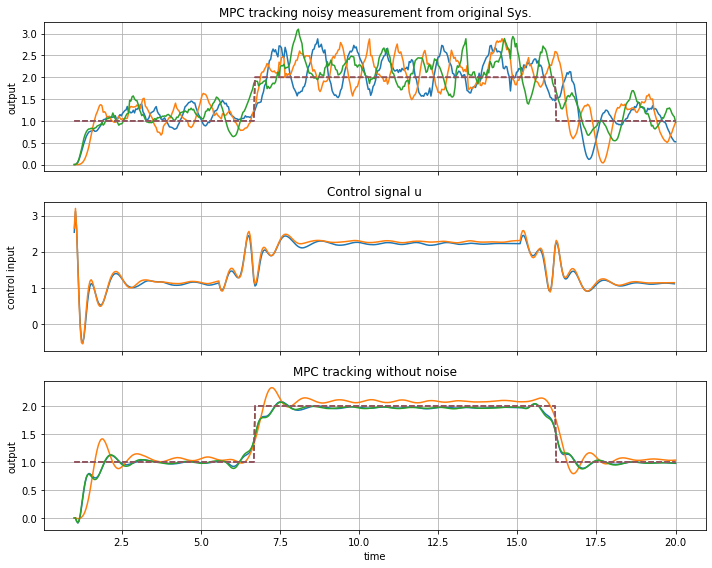

In [14]:
## results visualization ##
res_x_T = np.concatenate(res_x,axis=1)
res_u = np.array(res_u)
res_u = res_u.reshape(time.shape[0]-1,nu)

res_y = np.array(y_res)

y0 = np.zeros((ny,1))

res_y_withoutnoise = [y0]
for n in range(len(time)-1):
    temp = (Cb@res_x_T[:,n]).reshape(Cb.shape[0],1)
    res_y_withoutnoise.append(temp)
res_y_withoutnoise = np.array(res_y_withoutnoise).reshape(len(time),Cb.shape[0])


fig, ax = plt.subplots(3,1, figsize=(10,8), sharex=True)
ax[0].plot(time,res_y)
ax[0].set_title('MPC tracking noisy measurement from original Sys.')
ax[0].plot(time,REFERENCE.T[:N_sim], '--')
ax[0].set_ylabel('output')
ax[0].grid()

ax[1].set_title('Control signal u')
ax[1].plot(time[:-1],res_u)
ax[1].set_ylabel('control input')
ax[1].grid()

ax[2].plot(time,res_y_withoutnoise)
ax[2].plot(time,REFERENCE.T[:N_sim], '--')
ax[2].set_title('MPC tracking without noise')
ax[2].set_xlabel('time')
ax[2].set_ylabel('output')
ax[2].grid()

fig.align_ylabels()
fig.tight_layout()

plt.savefig('Acceleration_signal',dpi=250)

In [15]:
Ab.shape

(12, 12)